In [1]:
from itertools import count
import json
from pathlib import Path
import numpy as np
import IPython.display as disp
from osgeo import gdal
import pandas as pd

In [2]:
import ee
import folium 
import geehydro
import numpy as np # yes, numpy!
import pandas as pd # yes, pandas!
import proplot as plot 
import matplotlib.pyplot as plt 

C:\Users\talha\anaconda3\envs\pyhdf\lib\site-packages\proplot\__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


In [3]:
from ipygee import*
from pandas.plotting import register_matplotlib_converters

In [4]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWgn3lvOaWZnWsP4gvBvdVINc6QKpCNawnuPW255ejkolYNCS8Bhud4

Successfully saved authorization token.


In [34]:
dataset = ee.ImageCollection('MODIS/006/MOD13Q1').filter(ee.Filter.date('2020-01-01', '2020-12-31'))

In [35]:
ndvi = dataset.select('NDVI')

In [36]:
evi = dataset.select('EVI')

In [4]:
print(ndvi)

ee.ImageCollection({
  "functionInvocationValue": {
    "functionName": "Collection.map",
    "arguments": {
      "baseAlgorithm": {
        "functionDefinitionValue": {
          "argumentNames": [
            "_MAPPING_VAR_0_0"
          ],
          "body": {
            "functionInvocationValue": {
              "functionName": "Image.select",
              "arguments": {
                "bandSelectors": {
                  "constantValue": [
                    "NDVI"
                  ]
                },
                "input": {
                  "argumentReference": "_MAPPING_VAR_0_0"
                }
              }
            }
          }
        }
      },
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "ImageCollection.load",
                "arguments": {
                  "id": {
   

In [5]:
import folium
# Define the center of our map.
lat, lon = 23.730104, 90.306526
my_map = folium.Map(location=[lat, lon], zoom_start=10)
my_map

In [6]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [7]:
meanNDVI = ndvi.mean().multiply(0.0001)
vis_params = {
  'min': 0.0,
  'max': 1.0,
  'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901','66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01','012E01', '011D01', '011301'],
} 
# Define the center of our map.
lat, lon = 23.730104, 90.306526

my_map = folium.Map(location=[lat, lon], zoom_start=8)

my_map.add_ee_layer(meanNDVI, vis_params, 'NDVI')

In [8]:
# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

# calculating mean value of NDVI

In [18]:
geojson_path1 = list(Path(Path.cwd()/"Data"/"GeoJson").resolve().iterdir())[0]

countries = ['Malawi']
# get coordinates of the country
with open(geojson_path1) as f:
    data = json.load(f)
    coords = {}
    for j in countries:
        for i in data['features']:
            if i['properties']['name'] == j:
                coords[j] = i['geometry']['coordinates']
                break

In [19]:
#Define a region of interest as a point and buffer 1km around the area
# roi = ee.Geometry.Point([-124.0769, 40.1035]).buffer(1000)
roi = ee.Geometry.Polygon(coords['Malawi'])

#Get Image from Landsat

image = ee.Image(ee.ImageCollection('LANDSAT/LC08/C01/T1_RT')\
                     .filterDate('2014-01-01', '2014-01-01')\
                     .filterBounds(roi))

#Function from https://gis.stackexchange.com/q/360278

def meanNDVICollection (img,aoi):
    nir = img.select('B5')
    red = img.select('B4')
    ndviImage = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

    # Compute the mean of NDVI over the 'region'
    ndviValue = ndviImage.reduceRegion(**{
    'geometry': aoi.getInfo(),
    'reducer': ee.Reducer.mean(),
    }).get('NDVI');  # result of reduceRegion is always a dictionary, so get the element we want

    newFeature = ee.Feature(None, {
      # Adding computed NDVI value
      'NDVI': ndviValue
    }).copyProperties(img, [
      # Picking properties from original image
      'system:time_start'
    ])

    return newFeature

In [20]:
x = meanNDVICollection(image,roi)

In [21]:
# print(x.get('NDVI').getInfo())

In [24]:
print(x.get('NDVI'))

ee.ComputedObject({
  "functionInvocationValue": {
    "functionName": "Element.get",
    "arguments": {
      "object": {
        "functionInvocationValue": {
          "functionName": "Element.copyProperties",
          "arguments": {
            "destination": {
              "functionInvocationValue": {
                "functionName": "Feature",
                "arguments": {
                  "metadata": {
                    "dictionaryValue": {
                      "values": {
                        "NDVI": {
                          "functionInvocationValue": {
                            "functionName": "Dictionary.get",
                            "arguments": {
                              "dictionary": {
                                "functionInvocationValue": {
                                  "functionName": "Image.reduceRegion",
                                  "arguments": {
                                    "geometry": {
                                      

In [23]:
# calculate monthly average NDVI and plot against yield?

In [18]:
# calculate average monthly NDVI for Ukraine
# get MODIS NDVI
collection = ee.ImageCollection('MODIS/006/MOD13A1').select('NDVI')

# //import country boundaries
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')

# //Subset Ukraine feature from countries.
ukr = ee.Feature(countries.filter(ee.Filter.eq('country_na', 'Ukraine')).first())
print("ukr: ",ukr)

# //Use a function to iterate through months and calculate average NDVI
months = ee.List.sequence(1, 12)
print("months",months)
years = ee.List.sequence(2010, 2020)
print("years",years)

# // Map filtering and reducing across year-month combinations and convert to ImageCollection
yrMo = ee.ImageCollection.fromImages(
  years.map(function (y) {
        return months.map(function (m) {
            return collection
              .filter(ee.Filter.calendarRange(y, y, 'year'))
              .filter(ee.Filter.calendarRange(m, m, 'month'))
              .mean()
              .set('year',y)
              .set('month',m);
        });
    }).flatten());
print("yrMo",yrMo);

# //Define chart parameters
chartParam = {
 title: 'Monthly average NDVI',
  hAxis: {title: 'Time'},
  vAxis: {title: 'Average NDVI'},
}

# //Plot the chart
chart = ui.Chart.image.seriesByRegion({
  'imageCollection': yrMo,
  'region': ukr,
  'reducer': ee.Reducer.mean(),
  'scale': 500,
  'xProperty': 'system:index',
  'seriesProperty': 'PROJECT'
})
# //Print chart to console
print(chart.setOptions(chartParam))

SyntaxError: invalid syntax (3581980836.py, line 20)

# Version 3 (using MOD13Q1)

In [10]:
collection = ee.ImageCollection('MODIS/006/MOD13A1').select('NDVI')

# //import country boundaries
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')

# //Subset Ukraine feature from countries.
ukr = ee.Feature(countries.filter(ee.Filter.eq('country_na', 'Malawi')).first())
print("ukr: ",ukr)

ukr:  ee.Feature({
  "functionInvocationValue": {
    "functionName": "Collection.first",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.loadTable",
                "arguments": {
                  "tableId": {
                    "constantValue": "USDOS/LSIB_SIMPLE/2017"
                  }
                }
              }
            },
            "filter": {
              "functionInvocationValue": {
                "functionName": "Filter.equals",
                "arguments": {
                  "leftField": {
                    "constantValue": "country_na"
                  },
                  "rightValue": {
                    "constantValue": "Malawi"
                  }
                }
              }
            }
          }
        }
      }
    }
  }
}

In [11]:
# //Use a function to iterate through months and calculate average NDVI
months = ee.List.sequence(1, 12)
print("months",months)
years = ee.List.sequence(2010, 2020)
print("years",years)

months ee.List({
  "functionInvocationValue": {
    "functionName": "List.sequence",
    "arguments": {
      "end": {
        "constantValue": 12
      },
      "start": {
        "constantValue": 1
      }
    }
  }
})
years ee.List({
  "functionInvocationValue": {
    "functionName": "List.sequence",
    "arguments": {
      "end": {
        "constantValue": 2020
      },
      "start": {
        "constantValue": 2010
      }
    }
  }
})


In [15]:
Map = folium.Map(location=[-13.25, 34.5], zoom_start=8)

In [16]:
Map.addLayer(ukr)

In [17]:
Map

In [38]:
# MODIS MOD13Q1
modis = ee.ImageCollection('MODIS/006/MOD13Q1')
modis = modis.filterDate(ee.DateRange('2000-01-01','2019-12-01'))

In [20]:
# select EVI and NDVI
evi = modis.select('EVI')
ndvi = modis.select('NDVI')

In [23]:
def scale_factor(image):
# scale factor for the MODIS MOD13Q1 product
    return image.multiply(0.0001).copyProperties(image,['system:time_start'])

# mapping function to multiply by the scale factor
scaled_evi = evi.map(scale_factor)
scaled_ndvi = ndvi.map(scale_factor)

In [24]:
# mean NDVI in the Malawi
Map.addLayer(scaled_ndvi.mean().clip(ukr), vis_params={'min': 0,'max': 1,'palette': ['red', 'yellow','green']})

In [25]:
Map

In [26]:
ukr_ndvi = chart.Image.series(**{'imageCollection': scaled_ndvi,
                                   'region': ukr,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})
ukr_ndvi.renderWidget(width='50%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

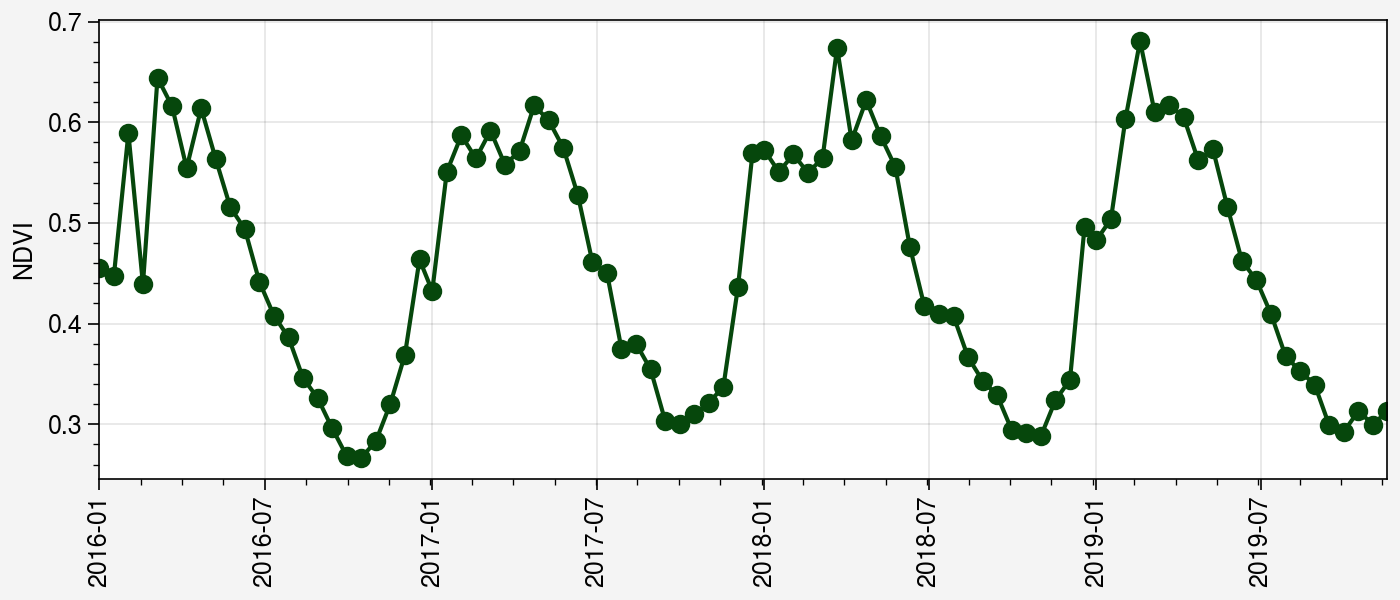

In [27]:
fig, ax = plot.subplots(figsize=(7, 3), tight=True)
ax.plot(ukr_ndvi.dataframe.index, ukr_ndvi.dataframe['NDVI'],
        color='forest green', marker='o')
plot.show()

In [29]:
ukr_ndvi.dataframe.head()

,NDVI
2016-01-01,0.454826
2016-01-17,0.447072
2016-02-02,0.589077
2016-02-18,0.438954
2016-03-05,0.644158


In [30]:
ukr_ndvi.dataframe.tail()

,NDVI
2019-09-14,0.298824
2019-09-30,0.292672
2019-10-16,0.313209
2019-11-01,0.299785
2019-11-17,0.313275


In [31]:
ukr_evi.dataframe.head()

NameError: name 'ukr_evi' is not defined

In [33]:
ukr_ndvi.dataframe.to_csv('NDVI_Malawi.csv')